In [2]:
import math

import cv2 as cv
import numpy as np

from google.colab.patches import cv2_imshow

from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def cosine_similarity(v1,v2):
  v1_mag = math.sqrt(np.dot(v1,v1))
  v2_mag = math.sqrt(np.dot(v2,v2))
  return abs(np.dot(v1,v2)/(v1_mag*v2_mag))



drive/  sample_data/


Imported 13233 faces


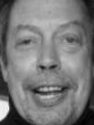

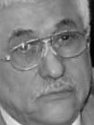

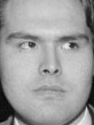

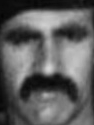

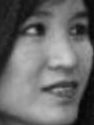

In [9]:
lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=1)
n_samples, h, w = lfw_people.images.shape

# lfw dataset image(s) aspect ratio
aRatio = h/w

X = lfw_people.data

n_features = X.shape[1]
face_dimensions = lfw_people.images[0].shape;

print(f'Imported {n_samples} faces')

for i in range(0,5):
  cv2_imshow(lfw_people.images[i]);

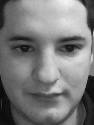

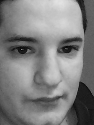

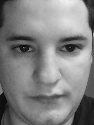

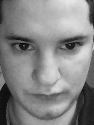

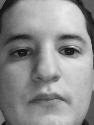

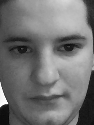

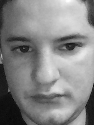

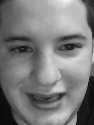

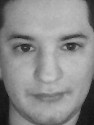

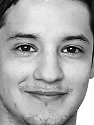

In [11]:


face_cascade = cv.CascadeClassifier('/content/haarcascade_frontalface_alt.xml');

def return_face(image):
  # Convert color image to grayscale for Viola-Jones
  grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  faces_bounding_boxes = face_cascade.detectMultiScale(grayscale_image)

  # iterate through bounding boxes
  for bb in faces_bounding_boxes:
      x, y, ww, hh = [ v for v in bb ]
      face = image[y:y+h, x:x+w]
      nw = (1/aRatio)*hh
      nh = aRatio*ww
      c = [x + (ww/2), y + (hh/2)]
      x_0 = c[0] - nw/2;
      x_1 = c[0] + nw/2
      y_0 = c[1] - nh/2
      y_1 = c[1] + nh/2
      cv.rectangle(
        image,
        (x, y),
        (x + ww, y + hh),
        (0, 255, 0),
        2
      )
      #cv2_imshow(image)
      rectFace = grayscale_image[y:y+hh,math.trunc(x_0):math.trunc(x_1)]
      face = cv.resize(rectFace, dsize=(face_dimensions[1], face_dimensions[0]), interpolation=cv.INTER_CUBIC)
      return face
  
faces = []

faces.append(return_face(cv.imread('/content/ae2.jpg')))
faces.append(return_face(cv.imread('/content/ae3.jpg')))
faces.append(return_face(cv.imread('/content/ae4.jpg')))
faces.append(return_face(cv.imread('/content/ae6.jpg')))
faces.append(return_face(cv.imread('/content/ae7.jpg')))
faces.append(return_face(cv.imread('/content/ae8.jpg')))
faces.append(return_face(cv.imread('/content/ae9.jpg')))
faces.append(return_face(cv.imread('/content/ae10.jpg')))
faces.append(return_face(cv.imread('/content/ae11.jpg')))
faces.append(return_face(cv.imread('/content/ae.jpeg')))


for face in faces:
    cv2_imshow(face) # originally: cv.imshow('Image', face)


In [24]:
n_components = 300

X_combined = np.concatenate((X,np.array([face.flatten() for face in faces])))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_combined)

def get_eigenface(image):
  return pca.transform([image.flatten()])[0]

In [28]:
#eigenfaces = pca.components_.reshape((n_components, h, w))
eigenfaces = np.array([get_eigenface(face) for face in faces])

# positive class training / test set
X_pos_train_pca, X_pos_test_pca = train_test_split(eigenfaces, test_size=0.25, random_state=42)

# negative class training / test set
X_neg_train, X_neg_test = train_test_split(X, test_size=0.25, random_state=42)
X_neg_train_pca = pca.transform(X_neg_train)
X_neg_test_pca = pca.transform(X_neg_test)

In [29]:
print(X[0].shape)
print(faces[0].flatten().shape)
print(X.shape)
print('---')
print(X_neg_train_pca.shape)
print(X_pos_train_pca.shape)
print(X_neg_test_pca.shape)
print(X_pos_test_pca.shape)

X_train = np.concatenate((X_neg_train_pca,X_pos_train_pca))
X_test = np.concatenate((X_neg_test_pca,X_pos_test_pca))

print(X_train.shape)
print(X_test.shape)

y_train = np.concatenate((np.zeros(X_neg_train_pca.shape[0]),np.ones(X_pos_train_pca.shape[0])))
y_test = np.concatenate((np.zeros(X_neg_test_pca.shape[0]),np.ones(X_pos_test_pca.shape[0])))
print(y_train.shape)
print(y_test.shape)


(11750,)
(11750,)
(13233, 11750)
---
(9924, 300)
(7, 300)
(3309, 300)
(3, 300)
(9931, 300)
(3312, 300)
(9931,)
(3312,)


In [30]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)

cov = qda.covariance_

print(qda.predict([get_eigenface(face) for face in faces]))
print(qda.predict(X_test))

qda.score(X_test, y_test)

[1. 0. 1. 1. 1. 0. 1. 1. 0. 1.]
[0. 0. 0. ... 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.9990942028985508

In [31]:
svc = svm.SVC()
#rbf, C=1.0
parameters = {'kernel':('linear', 'rbf'), 'C':[1,2,4,10]}
clf = GridSearchCV(svc, parameters)
model_params = clf.fit(X_train, y_train)
print(model_params)
clf.score(X_test, y_test)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 4, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


0.9993961352657005

In [23]:
test_face = get_eigenface(return_face(cv.imread('/content/ae10.jpg')))

clf.predict([test_face])

array([1.])

In [1]:
similarities = []

for obs in X_neg_test_pca:
  sim = cosine_similarity(obs,get_eigenface(faces[0]))
  similarities.append(sim)

print('---original----')
cv2_imshow(faces[0])


print('---max-similarity-in-dataset---')
i = similarities.index(max(similarities))
cv2_imshow(lfw_people.images[i])
print(similarities[i])
print(type(lfw_people.images[i]))

for i, eigenface in enumerate(eigenfaces):
  cv2_imshow(faces[i])
  print(cosine_similarity(eigenfaces[0],eigenface))

NameError: ignored